In [21]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split # train_test split 만 필수
#from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline #(옵션)
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, average_precision_score
) # 필요한 것 만 선택해도 됌

# 아래 모델들을 -> 트리기반 (tree-based) -> scailing 필요 없음
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [22]:
RNG = 42 # seed number

# 1) 데이터 로드
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")  # 0=malignant, 1=benign

print("Dataset shape:", X.shape)
print("Target distribution:\n", y.value_counts(normalize=True).rename({0:"malignant", 1:"benign"}))

Dataset shape: (569, 30)
Target distribution:
 target
benign       0.627417
malignant    0.372583
Name: proportion, dtype: float64


- 진짜 최소한으로 전처리를 하고 싶다?
- 머신러닝에 돌아갈 정도면 된다!
- 결측값 처리(XGB는 예외), 범주형 변수 인코딩(Catboost 예외) -> 트리기반 모델은 잊어도도 충분!

### 추석 과제 주요 질문
- 머신 러닝 프로세스 어려운 것 -> 트리기반 모델 권장
- 인사이트 도출 어떻게 하는거지? -> 기술적인 결과를 얻는거는 통계적 유의성, 머신러닝 결과 보면 되는데... 그걸 넘어서서 인사이트? -> 정답X
    - 도메인 지식이 짱이다 (잘 아는 분야, 좋아하는 분야)
    - 많은 데이터를 프로젝트를 통해 경험을 쌓는게 중요하죠 
- 가설검정을 머신러닝에 어떻게 이끄는가? 통계적 유의성과 머신러닝 예측중 어떤 결과를 우선시? 머신러닝 결과랑 통계적 결과 어떻게 연결?

### 가설 검정 진행
- 가설 검정 결과 vs 머신러닝 결과
    - 가설검정(통계적 추론)은 “두 집단(혹은 그 이상의 집단)이 평균/분포 면에서 유의하게 다른가?” -> 현재/과거의 느낌
    - 머신러닝(예측)은 “보지 못한 샘플의 라벨을 얼마나 잘 맞추는가?” -> 미래의 느낌
    - 두개는 목적이 아예 다른 것!
- 가설 검정과 머신러닝 결과를 같이 보는 경우
    - 가설 검정에서 유의하지만 머신러닝 예측은 별로인 경우
        - 효과는 있지만 작다(d, r이 작음) → 통계적으로는 감지되나 실무 예측력은 미약
        - 중복/공선성으로 모델에선 추가 이득이 거의 없을 가능성이 높음
        - 변수 선택이나 차원 축소 기법을 검토할 필요 있음
    - 가설 검정에서 유의하지 않지만 머신러닝 예측이 괜찮 경우
        - 단변량으론 미미하지만 다른 피처와의 상호작용/비선형에서 정보가 살아남음
        - 여러 변수를 함께 보거나 비선형 해석이 추가로 필요할 수 있음
          
- 효과크기
    - 원래 표본 크기가 커지면 작은 차이도 쉽게 유의하다고 할 수 있음 -> 표본크기와 상관없이 차이가 큰지?에 대한 지표
    - t-test → Cohen’s d, Mann–Whitney → rank-biserial r. (카이제곱 쓸 때는 cramer's V)
    - p < α & 효과크기 큼 → “통계적으로도, 실무적으로도 의미 있음.” ⟶ 적극 채택/비즈니스에 반영.
    - p < α & 효과크기 작음 → “있긴 있는데 매우 작은 차이.” ⟶ 과잉해석 금지, 비용-편익 검토.
    - p ≥ α & 효과크기 큼 → “표본이 부족해서 힘이 약했을 수 있음.” ⟶ 표본 확장/검정 재평가.
    - p ≥ α & 효과크기 작음 → “의미 있는 차이 없음.” ⟶ 현상 유지, 다른 변수/모델 탐색.


=== Hypothesis Test on 'mean radius' ===
Shapiro (malignant): W=0.978, p=0.00189 -> normal=False
Shapiro (benign)   : W=0.997, p=0.668 -> normal=True
Levene equal var   : W=90.477, p=5.28e-20 -> equal_var=False

[Nonparametric] Mann–Whitney U: U=70955.0, p=2.69e-68
Rank-biserial r: -0.875


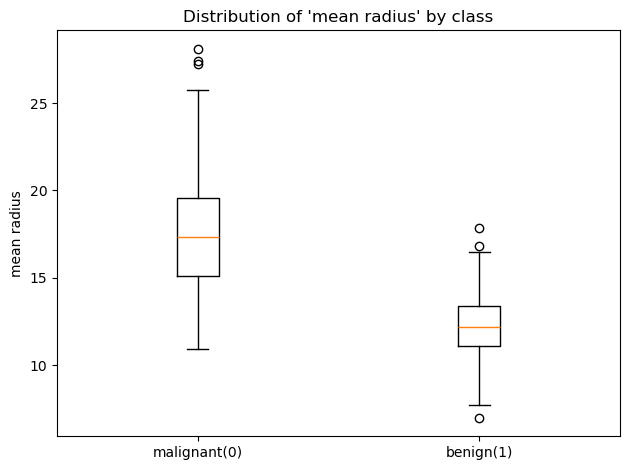

In [3]:
# 2) 가설검정: 악성 vs 양성에서 특정 feature 평균 차이
def cohen_d(x, y):
    nx, ny = len(x), len(y)
    vx, vy = np.var(x, ddof=1), np.var(y, ddof=1)
    pooled = ((nx-1)*vx + (ny-1)*vy) / (nx + ny - 2)
    return (np.mean(x) - np.mean(y)) / np.sqrt(pooled)

def rank_biserial(u_stat, n1, n2):
    return 1 - (2*u_stat)/(n1*n2)

feature_to_test = "mean radius" # 종양의 반지름 크기?
x0 = X.loc[y==0, feature_to_test].values  # malignant
x1 = X.loc[y==1, feature_to_test].values  # benign

sw0 = stats.shapiro(x0)
sw1 = stats.shapiro(x1)
levene = stats.levene(x0, x1, center="median")

normal0, normal1 = sw0.pvalue > 0.05, sw1.pvalue > 0.05
equal_var = levene.pvalue > 0.05

print(f"\n=== Hypothesis Test on '{feature_to_test}' ===")
print(f"Shapiro (malignant): W={sw0.statistic:.3f}, p={sw0.pvalue:.3g} -> normal={normal0}")
print(f"Shapiro (benign)   : W={sw1.statistic:.3f}, p={sw1.pvalue:.3g} -> normal={normal1}")
print(f"Levene equal var   : W={levene.statistic:.3f}, p={levene.pvalue:.3g} -> equal_var={equal_var}")

if normal0 and normal1:
    t_res = stats.ttest_ind(x0, x1, equal_var=equal_var)
    d = cohen_d(x0, x1)
    print(f"\n[Parametric] t-test(equ_var={equal_var}): t={t_res.statistic:.3f}, p={t_res.pvalue:.3g}")
    print(f"Cohen's d: {d:.3f}")
else:
    u_res = stats.mannwhitneyu(x0, x1, alternative="two-sided")
    r_rb = rank_biserial(u_res.statistic, len(x0), len(x1))
    print(f"\n[Nonparametric] Mann–Whitney U: U={u_res.statistic:.1f}, p={u_res.pvalue:.3g}")
    print(f"Rank-biserial r: {r_rb:.3f}")

plt.figure()
plt.boxplot([x0, x1], labels=["malignant(0)", "benign(1)"])
plt.title(f"Distribution of '{feature_to_test}' by class")
plt.ylabel(feature_to_test)
plt.tight_layout()
plt.show()


In [20]:
# 3) 학습/평가 분리 + CV 설정
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RNG, stratify=y # 분류인 경우에는 stratify 중요! -> 분류인 경우에는 종속변수를 넣으면 됌
) # test 데이터를 먼저 떼 놓으면 더 좋긴 함
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG) # 데이터 개수가 작을 때 쓰면 좋아요

# 4) 모델 정의 (앙상블 모델 중에서 괜찮은 것들)
models = []

rf = Pipeline([
    ("clf", RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        random_state=RNG
    ))
])
models.append(("RandomForest", rf))

xgb = Pipeline([
    ("clf", XGBClassifier(
        n_estimators=350,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.8,
        eval_metric="logloss",
        tree_method="hist",  # CPU 빠름
        random_state=RNG,
        n_jobs=-1
    ))
])
models.append(("XGBoost", xgb))

lgbm = Pipeline([
    ("clf", LGBMClassifier(
        n_estimators=400,
        max_depth=-1,
        num_leaves=31,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.8,
        random_state=RNG,
        n_jobs=-1
    ))
])
models.append(("LightGBM", lgbm))

cat = Pipeline([
    ("clf", CatBoostClassifier(
        iterations=500,
        depth=4,
        learning_rate=0.05,
        loss_function="Logloss",
        eval_metric="AUC",
        random_state=RNG,
        verbose=False
    ))
])
models.append(("CatBoost", cat))

In [18]:
# 5) 교차검증 평가
scoring = {
    "accuracy": "accuracy",
    "f1": "f1",
    "precision": "precision",
    "recall": "recall",
    "roc_auc": "roc_auc",
    "pr_auc": "average_precision"
}

rows = []
for name, pipe in models:
    scores = cross_validate(
        pipe, X_train, y_train, cv=cv, scoring=scoring,
        return_train_score=False, n_jobs=-1
    )
    rows.append({
        "model": name,
        "ACC(mean)": np.mean(scores["test_accuracy"]),
        "F1(mean)": np.mean(scores["test_f1"]),
        "Precision(mean)": np.mean(scores["test_precision"]),
        "Recall(mean)": np.mean(scores["test_recall"]),
        "ROC-AUC(mean)": np.mean(scores["test_roc_auc"]),
        "PR-AUC(mean)": np.mean(scores["test_pr_auc"])
    })

results_cv = pd.DataFrame(rows).sort_values("ROC-AUC(mean)", ascending=False)
print("\n=== 5-Fold CV Results (Train split) ===")
print(results_cv.round(4).to_string(index=False))


=== 5-Fold CV Results (Train split) ===
       model  ACC(mean)  F1(mean)  Precision(mean)  Recall(mean)  ROC-AUC(mean)  PR-AUC(mean)
     XGBoost     0.9736    0.9790           0.9757        0.9825         0.9937        0.9957
    CatBoost     0.9736    0.9789           0.9756        0.9825         0.9932        0.9954
    LightGBM     0.9714    0.9773           0.9724        0.9825         0.9929        0.9953
RandomForest     0.9604    0.9683           0.9689        0.9684         0.9906        0.9932


In [19]:
# 6) 홀드아웃 테스트셋 평가
def eval_on_test(pipe, X_tr, y_tr, X_te, y_te):
    pipe.fit(X_tr, y_tr)
    pred = pipe.predict(X_te)
    proba = pipe.predict_proba(X_te)[:,1] if hasattr(pipe[-1], "predict_proba") else None
    out = {
        "ACC": accuracy_score(y_te, pred),
        "F1": f1_score(y_te, pred),
        "Precision": precision_score(y_te, pred),
        "Recall": recall_score(y_te, pred),
    }
    if proba is not None:
        out["ROC-AUC"] = roc_auc_score(y_te, proba)
        out["PR-AUC"]  = average_precision_score(y_te, proba)
    return out, proba

test_rows, probas = [], {}
for name, pipe in models:
    metrics, p = eval_on_test(pipe, X_train, y_train, X_test, y_test)
    metrics["model"] = name
    test_rows.append(metrics)
    if p is not None:
        probas[name] = p

results_test = pd.DataFrame(test_rows).set_index("model").round(4)
print("\n=== Test Set Results ===")
print(results_test.to_string())

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 285, number of negative: 170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4542
[LightGBM] [Info] Number of data points in the train set: 455, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626374 -> initscore=0.516691
[LightGBM] [Info] Start training from score 0.516691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

- 테스트 데이터까지 결과가 잘 나왔다? -> 학습한 모델을 이제는 새로운데이터에 적용해서 예측!
- 질문 ) 머신러닝 프로세스에서 모델 평가 후에 실제 활용을 코드로 어떻게 실행하냐?
- 저번에 회귀 모델 다루었을 때 경원 튜터님 보험료 예측한 예시! 경원 만 17세 -> 보험비 유리

- 트리기반의 장점이자, 머신러닝 모델 하고 나서 보면 좋은 거는 -> feature importance (트리기반 모델이 아니면 파라미터 theta)
- 머신러닝의 최대 단점! -> black box -> 머신러닝이 결과는 잘 예측하는데 그 과정을 알 수가 없음 (딥러닝이 굉장히 심함)
- (의사결정트리, 선형회귀, 로지스틱회귀 -> 얘네들은 괜찮음, 과정을 알 수 있음)
- trade off (하나가 좋으면 하나는 반드시 안좋은경우)
    - 성능 vs 해석 -> trade off 관계
    - 의사결정트리 -> 단순, 성능은 상대적으로 낮은데, 해석은 잘 돼요
    - 앙상블기반 모델 -> 복잡, 성능은 상대적으로 높은데, 해석이 잘 안돼요 

- XAI (eXplainable AI) -> 2019년부터 활발하게 연구되기 시작
    - AI를 도와서 설명을 가능하게 해주는 기법
    - SHAP, LIME 